In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clawpack.pyclaw.solution as solution
from clawpack import riemann
import shallow_1D_redistribute
%matplotlib inline

In [2]:
def wall_q(x, num_ghost):
    x_bc = np.zeros((x.shape[0], x.shape[1] + 2*num_ghost))
    x_bc[:,num_ghost:-num_ghost] = x
    x_bc[0,1] = x_bc[0,2]
    x_bc[1,1] = -x_bc[1,2]
    x_bc[:,0] = x_bc[:,1]
    x_bc[0,-2] = x_bc[0,-3]
    x_bc[1,-2] = -x_bc[1,-3]
    x_bc[:,-1] = x_bc[:,-2]
    
    return x_bc

def wall_aux(x, num_ghost):
    x_bc = np.zeros((x.shape[0], x.shape[1] + 2*num_ghost))
    x_bc[:,num_ghost:-num_ghost] = x
    x_bc[:,1] = x_bc[:,2]
    x_bc[:,0] = x_bc[:,1]
    x_bc[:,-2] = x_bc[:,-3]
    x_bc[:,-1] = x_bc[:,-2]
    
    return x_bc

def cfl_t(s,dx,cfl,LL,UL):
    sdx = 0.0
    for mw in xrange(s.shape[0]):
        smax1 = np.max(s[mw,LL-1:UL-1]/x_size)
        smax2 = np.max(-s[mw,LL-1:UL-1]/x_size)
        sdx = max(sdx,smax1,smax2)
        
    return cfl/sdx

def load_parameters(fileName):
    fileObj = open(fileName)
    params = {}
    for line in fileObj:
        line = line.strip()
        key_value = line.split('=')
        params[key_value[0]] = key_value[1]
    return params

In [3]:
params = load_parameters('parameters_edge.txt')
xlower = float(params['xlower'])
xupper = float(params['xupper'])
cells_number = int(params['cells_number'])
nw = int(params['wall_position']) # index of the edge used to present the wall
wall_height = float(params['wall_height'])

In [4]:
problem_data = {}
problem_data['grav'] = 9.8
problem_data['sea_level'] = 0.0
problem_data['wall_position'] = nw
problem_data['wall_height'] = wall_height
problem_data['dry_tolerance'] = 0.001
problem_data['max_iteration'] = 1
problem_data['zero_width'] = True

In [5]:
error_h= []
num_eqn = 2
num_waves = 2
num_ghost = 2

t_final = 1.0
cfl = 0.8

iw = nw + num_ghost - 1
aux_initial = np.ones((1, cells_number))*(-0.8)

q_initial = np.zeros((num_eqn, cells_number))
q_initial[0,:] = 0.0 - aux_initial[0,:]
q_initial[0,:] = q_initial[0,:].clip(min=0)
q_initial[0,:nw-5] += 0.4
q_initial[1,:] = 0.0

q = q_initial.copy()
aux = aux_initial.copy()

x_size = (xupper-xlower)/cells_number
    
dx = np.ones(cells_number + 2*num_ghost)*x_size

LL = num_ghost - 1
UL = num_ghost + cells_number + 1

q_bc = wall_q(q, num_ghost)
aux_bc = wall_aux(aux, num_ghost)
q_l = q_bc[:,:-1].copy()
q_r = q_bc[:,1:].copy()
aux_l = aux_bc[:,:-1].copy()
aux_r = aux_bc[:,1:].copy()

wave,s,amdq,apdq = shallow_1D_redistribute.shallow_fwave_dry_1d(q_l, q_r, aux_l.copy(), aux_r.copy(), problem_data)

dt = cfl_t(s,x_size,cfl,LL,UL)
dtdx = dt/dx
t_next = 0.0
t_next += dt
t_steps = [0.0]
t_steps.append(dt)


while t_next < t_final:
    
    for m in xrange(num_eqn):
        q_bc[m,LL:UL] -= dtdx[LL:UL]*(apdq[m,LL-1:UL-1])
        q_bc[m,LL-1:UL-1] -= dtdx[LL-1:UL-1]*(amdq[m,LL-1:UL-1])
    q = q_bc[:,num_ghost:-num_ghost]
    error_h.append((sum(q[0,:]*dx[num_ghost:-num_ghost]) - sum(q_initial[0,:]*dx[num_ghost:-num_ghost]))/sum(q_initial[0,:]*dx[num_ghost:-num_ghost]))
    
    # calucate the data for next update
    q_bc = wall_q(q, num_ghost)
    q_l = q_bc[:,:-1].copy()
    q_r = q_bc[:,1:].copy()

    wave,s,amdq,apdq = shallow_1D_redistribute.shallow_fwave_dry_1d(q_l, q_r, aux_l.copy(), aux_r.copy(), problem_data)
    dt = cfl_t(s,x_size,cfl,LL,UL)
    t_next += dt
    t_steps.append(t_next)
    dtdx = dt/dx

dt = t_final - (t_next - dt)
t_steps[-1] = t_final
dtdx = dt/dx
for m in xrange(num_eqn):
    q_bc[m,LL:UL] -= dtdx[LL:UL]*(apdq[m,LL-1:UL-1])
    q_bc[m,LL-1:UL-1] -= dtdx[LL-1:UL-1]*(amdq[m,LL-1:UL-1])
q = q_bc[:,num_ghost:-num_ghost]  

error_h.append((sum(q[0,:]*dx[num_ghost:-num_ghost]) - sum(q_initial[0,:]*dx[num_ghost:-num_ghost]))/sum(q_initial[0,:]*dx[num_ghost:-num_ghost]))


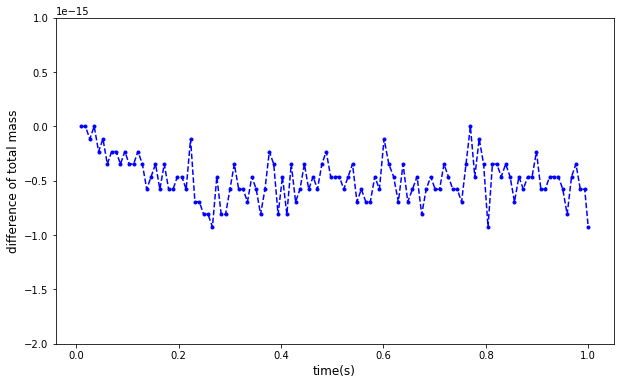

In [6]:
fig = plt.figure(figsize=(10,6))

plt.plot(t_steps[1:], error_h, 'b--.')

# plt.title("Comparison of Errors for h")
plt.xlabel("time(s)", fontsize=12)
plt.ylabel("difference of total mass", fontsize=12)
# plt.ylabel("$\sum h(t) - \sum h(0)$")
plt.ylim([-2e-15,1e-15])
plt.show()
fig.savefig('mass_conservation.pdf')

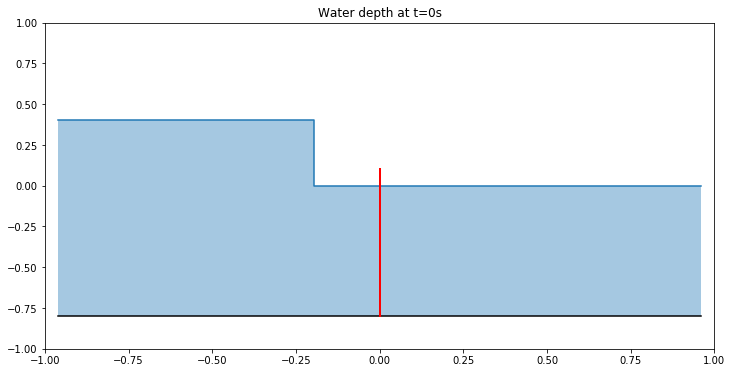

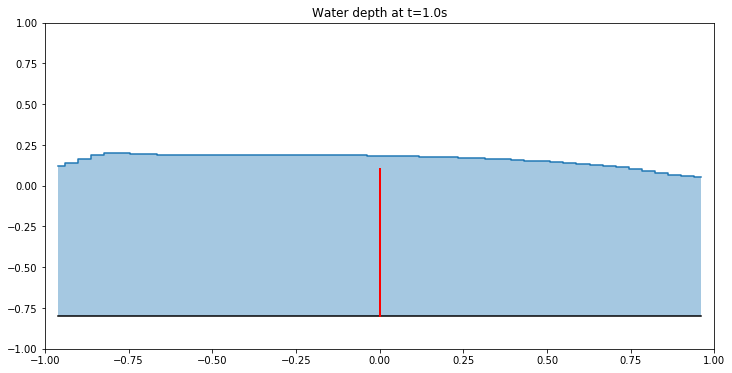

In [7]:
xc = np.linspace(xlower+x_size, xupper-x_size, len(q_initial[0,:]))
plt.figure(figsize=(12,6))
plt.fill_between(xc, q_initial[0,:]+aux_initial[0,:],y2=aux_initial[0,:], step="mid", alpha=0.4)
plt.step(xc, q_initial[0,:]+aux_initial[0,:], where='mid')
plt.step(xc, aux_initial[0,:], 'k', where='mid')
x_wall = nw*x_size+xlower
y1 = 0.5*(aux_initial[0,nw-1] + aux_initial[0,nw])
y2 = y1 + wall_height
plt.plot([x_wall,x_wall],[y1,y2],'r',linewidth=2)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Water depth at t=0s")
plt.show()

plt.figure(figsize=(12,6))
plt.fill_between(xc, q[0,:]+aux_initial[0,:],y2=aux_initial[0,:], step="mid", alpha=0.4)
plt.step(xc, q[0,:]+aux_initial[0,:], where='mid')
plt.step(xc, aux_initial[0,:], 'k', where='mid')
x_wall = nw*x_size+xlower
y1 = 0.5*(aux_initial[0,nw-1] + aux_initial[0,nw])
y2 = y1 + wall_height
plt.plot([x_wall,x_wall],[y1,y2],'r',linewidth=2)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Water depth at t="+ str(t_final)+"s")
plt.show()